In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

Using TensorFlow backend.
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflo

In [4]:
base = pd.read_csv('petr4-treinamento.csv')
base = base.dropna()
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [5]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1242 entries, 0 to 1244
Data columns (total 7 columns):
Date         1242 non-null object
Open         1242 non-null float64
High         1242 non-null float64
Low          1242 non-null float64
Close        1242 non-null float64
Adj Close    1242 non-null float64
Volume       1242 non-null float64
dtypes: float64(6), object(1)
memory usage: 77.6+ KB


In [3]:
#variavel que queremos fazer as previsões, no caso o preço de abertura do dia
# coloca-se [:, 1:2] e não [:, 1], pois no primeiro caso manda um array e no segundo só o valor de fato
# para conseguir aplicar a normalização necessita ser dessa meneira
base_treinamento = base.iloc[:, 1:2].values

In [4]:
base_treinamento[0]

array([19.99])

In [5]:
# Vamos precisar fazer ruma normalização nesses dados, pos quando se trabalha com esse tipo de rede neural,
# como existem muitas camadas e principalmente o fato de cada camada apontar pra ela mesma para passar informação
# ele pode ficar bastante lento se for utilizado os valores reais, então vamos aplicar uma normalização para que 
# consigamos colocar esses valores em uma escala de 0 até 1


normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

# Tem que definir o intervalo de tempo, no caso será 4 dias, ou seja, 4 preços da ação para predizer no quinto.
# Precisará começar no quinto registro pois o intervalo escolhido foi de 4 preços então antes disso não teria os registros necessarios para iniciar.
# Fazer um pre processamento pra gerar uma base de dados no fromato abaixo.

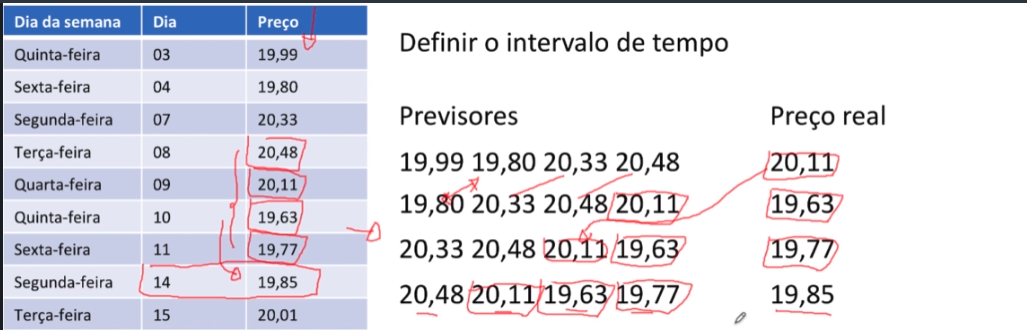

In [6]:
base_treinamento_normalizada.shape

(1242, 1)

## No código, queremos prever o preço da ação baseado nos 90 valores anteriores, então irá começar a partir do valor de indice 90

## Preencher dois vetores, o de previsores e o de preço real

## previsores: a cada iteração retira do "base_treinamento_normaliza" e vai retirando os preços de 90 em 90, por exemplo, primeiro tira os valores de '0 a 89', depois '1 a 90', '2 a 91'e etc... Sempre assim de 90 em 90, colocando cada grupo desses 90 em cada coluna da variavel previsores

## preço_real: a cada iteração coloca um valor a partir do indice 90 de "base_treinamento_normalizada'.

In [7]:
previsores = []
preco_real = []

for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real.append(base_treinamento_normalizada[i, 0])


# converter para array e necessario para passar os dados como parametros para a rede neural    
previsores, preco_real = np.array(previsores), np.array(preco_real)

In [8]:
previsores.shape

(1152, 90)

In [9]:
preco_real.shape

(1152,)

## O exemplo acima está ilustrado abaixo, onde nas linhas temos os registros e a tabela do preço real(para comparar após predição) a direit. 
## Os previsores(que serão utilizados para a modelagem em um intervalo de 90 registros/preços) a esquerda.

## Tal qual no exemplo ilustrado na imagem acima

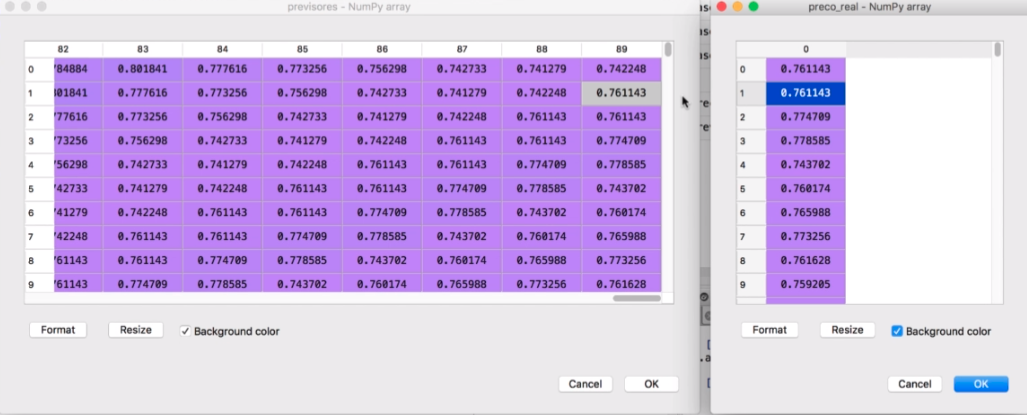

## Na RNN tem um formato de input shape, configurada na imagem

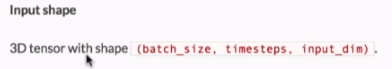

## 'batch_size': Se referindo a quantidade de registros.

## 'timesteps': Quantos intervalos de tempo, que seriam as colunas, que poderiam ser, por exemplo, t1, t2, t3, cada coluna representa uma unidade do preço da ação no tempo.

## 'input_dim': Temos somente um indicador, no caso 'open', apenas a coluna 'open' e com base desses dados dessa coluna no passado quero prever no futuro. Caso queria utilizar mais atributos previsores pode-se aumentar a dimensionalidade no terceiro item.

In [10]:
# previsores.shape[0] = 1152, número de registros
# previsores.shape[1] = 90, colunas, preço da ação na unidade de tempo, no caso em 90 unidades de tempo
# 1 = apenas referente a coluna 'open', um indicador. Com base nos dados da coluna open no passado quero prever os dados da coluna open no futuro.

previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

# Estrutura da Rede Neural

In [11]:
regressor = Sequential()

# units equivale a o número de células de memoria, deve ser um número grande pra adicionar mais dimensionalidade
# e caputar a tendência no decorrer do tempo, se for um valor muito baixo não irá conseguir capturar variação temporal
# return_sequences = utiliza somente quando terá mais de uma camada LSTM, indica irá passar a informação para as próximas camadas subsequentes
# abaixo a primeira camada
regressor.add(LSTM(units = 100, return_sequences = True, input_shape =(previsores.shape[1], 1) ))
regressor.add(Dropout(0.3))
# Com esse tipode rede neural é interessente adicionar mais camdas para ter bons resultados, nesse caso serão 4.

# Aqui pode-se reduzir o número de neuronios/células de memória, em alguns casos pode-se colocar valor mais alto nos primeiro e depois dimuir, fazer testes para verificar resultados
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Retira o 'return_sequences', só colocar quando tem mais camadas subsequentes
# No caso, após, é somente a camada de saída.
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

#camada de saída, como é apenas a coluna 'open', somente uma unit, fazer teste com 'sigmoid' é uma alternativa.
regressor.add(Dense(units = 1, activation = 'linear'))


W0905 10:07:20.018929 139672598935360 deprecation_wrapper.py:119] From /home/jarbasjr/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 10:07:20.076542 139672598935360 deprecation_wrapper.py:119] From /home/jarbasjr/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 10:07:20.091782 139672598935360 deprecation_wrapper.py:119] From /home/jarbasjr/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 10:07:20.519122 139672598935360 deprecation_wrapper.py:119] From /home/jarbasjr/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

In [12]:
# RMSprop é um otimizador para RNN.
# "mean_squared_error" calculo de erro mais eficiente de calculo do erro.
# "mean_absolute_error" como ele faz absoluto fica mais facil entender os resultados.

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                         metrics = ['mean_absolute_error'])

W0905 10:07:21.732136 139672598935360 deprecation_wrapper.py:119] From /home/jarbasjr/.local/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [13]:
# interessante rodar PELO MENOS umas 100 epócas se não ele tende a não se adaptar aos dados.
regressor.fit(previsores, preco_real, epochs =100, batch_size = 32 )

W0905 10:07:22.279282 139672598935360 deprecation.py:323] From /home/jarbasjr/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0905 10:07:27.125423 139672598935360 deprecation_wrapper.py:119] From /home/jarbasjr/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/100
1152/1152 [==============================] - 14s 12ms/step - loss: 0.0380 - mean_absolute_error: 0.1402
Epoch 2/100
1152/1152 [==============================] - 8s 7ms/step - loss: 0.0165 - mean_absolute_error: 0.0991
Epoch 3/100
1152/1152 [==============================] - 8s 7ms/step - loss: 0.0130 - mean_absolute_error: 0.0870
Epoch 4/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.0115 - mean_absolute_error: 0.0830
Epoch 5/100
1152/1152 [==============================] - 5s 5ms/step - loss: 0.0107 - mean_absolute_error: 0.0797
Epoch 6/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.0093 - mean_absolute_error: 0.0741
Epoch 7/100
1152/1152 [==============================] - 8s 7ms/step - loss: 0.0090 - mean_absolute_error: 0.0728
Epoch 8/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.0073 - mean_absolute_error: 0.0647
Epoch 9/100
1152/1152 [==============================] - 8s 7ms/step - loss: 0.0078 - 